In [1]:
# Artificial Neural Network (ANN) from scratch (i.e.,
# without using built-in functions). Implement the back-propagation algorithm to learn the weights of an
# ANN with 2 input nodes, 2 hidden nodes and 1 output node. The hidden layer nodes employ a sigmoid
# nonlinearity. Use squared-error loss. Train your network to learn the following binary operations:
# 1. XOR
# 2. AND
# 3. OR

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [305]:
class ArtificialNeuralNetwork:
    def __init__(self):
        '''
        Initialize the Artificial Neural Network with default parameters
        '''
        self.learning_rate = 0.1
        self.epochs = 1000
        self.batch_size = 16
        self.training_method = "deterministic_gradient_descent"
        self.layers = []
        self.weights = []
        self.biases = []
    
    def addLayer(self, n, input_shape = None):
        if input_shape is not None:
            if len(self.layers) != 0:
                print('Current layer cannot be the input layer')
                return
            self.layers.append(input_shape)
        else:
            if len(self.layers) == 0:
                print('Please specify input shape for the first layer')
                return
        np.random.seed(30) # for reproducibility
        self.weights.append(np.random.uniform(-1, 1, (self.layers[-1], n)).astype(np.float64))
        self.biases.append(np.random.uniform(-1, 1, (1, n)).astype(np.float64))
        # self.biases.append(np.zeros((1, n)).astype(np.float64))
        self.layers.append(n)
    
    def printStructure(self):
        print('Layers:', self.layers)
        print('Weights:', self.weights)
        print('Biases:', self.biases)
    
    def sigmoid(self, inp):
        outp = 1 / (1 + np.exp(-inp))
        return outp
    
    def gradSigmoid(self, inp):
        outp = self.sigmoid(inp) * (1 - self.sigmoid(inp))
        return outp
    
    def softmax(self, inp):
        outp = np.exp(inp) / np.sum(np.exp(inp))
        return outp
    
    def gradSoftmax(self, inp):
        outp = self.softmax(inp) * (1 - self.softmax(inp))
        return outp
    
    def squaredError(self, y, y_hat):
        return np.sum((y_hat - y) ** 2)/len(y)
    
    def gradSquaredError(self, y, y_hat):
        return 2*(y_hat - y)/len(y)
    
    def forwardPropagate(self, input):
        a_arr = []
        z_arr = []
        for i in range(len(self.weights)-1):
            if i == 0:
                a = np.dot(input, self.weights[i]) + self.biases[i]
                # a = np.dot(input, self.weights[i])
            else:
                a = np.dot(z_arr[-1], self.weights[i]) + self.biases[i]
                # a = np.dot(z_arr[-1], self.weights[i])
            z = self.sigmoid(a)
            a_arr.append(a)
            z_arr.append(z)

        # using sigmoid for the last layer
        a = np.dot(z_arr[-1], self.weights[-1]) + self.biases[-1]
        # a = np.dot(z_arr[-1], self.weights[-1])
        z = self.sigmoid(a)
        a_arr.append(a)
        z_arr.append(z)

        return a_arr, z_arr
    
    def computeGradients(self, inputs, targets, a_arr, z_arr):
        gradients = []
        gradients_bias = []
        for i in range(len(a_arr)-1, 0, -1):
            if i == len(a_arr)-1:
                prv = self.gradSquaredError(targets, z_arr[i]) * self.gradSigmoid(a_arr[i])
                grd = z_arr[i-1].T @ prv
                grd_bias = np.sum(prv, axis=0)
                gradients.append(grd)
                gradients_bias.append(grd_bias)
            else:
                prv = (prv @ self.weights[i+1].T) * self.gradSigmoid(a_arr[i])
                grd = z_arr[i-1].T @ prv
                grd_bias = np.sum(prv, axis=0)
                gradients.append(grd)
                gradients_bias.append(grd_bias)
        prv = (prv @ self.weights[1].T) * self.gradSigmoid(a_arr[0])
        grd = inputs.T @ prv
        grd_bias = np.sum(prv, axis=0)
        gradients.append(grd)
        gradients_bias.append(grd_bias)

        # reverse the gradients
        gradients.reverse()
        gradients_bias.reverse()

        return gradients, gradients_bias

    def updateParameters(self, gradients, gradients_bias, learning_rate):
        for i in range(len(gradients)):
            self.weights[i] = self.weights[i] - learning_rate * gradients[i]
            self.biases[i] = self.biases[i] - learning_rate * gradients_bias[i]

    def backPropagate(self, inputs, targets, a_arr, z_arr, learning_rate):
        gradients, gradients_bias = self.computeGradients(inputs, targets, a_arr, z_arr)
        self.updateParameters(gradients, gradients_bias, learning_rate)
    
    def predict(self, inputs):
        a_arr, z_arr = self.forwardPropagate(inputs)
        return z_arr[-1]
    
    def accuracy(self, y, y_hat):
        if self.layers[-1] == 1:
            print(y, y_hat, np.round(y_hat))
            return np.sum(y == np.round(y_hat))/len(y)
        return np.sum(np.argmax(y, axis=1) == np.argmax(y_hat, axis=1))/len(y)
    
    def train(self, inputs, targets, test_inputs, test_targets, batch_size=None, epochs=None, learning_rate=None, training_method=None, verbose=True):
        if batch_size is None:
            batch_size = self.batch_size
        if epochs is None:
            epochs = self.epochs
        if learning_rate is None:
            learning_rate = self.learning_rate
        if training_method is None:
            training_method = self.training_method
        
        if self.layers[-1] != 1:
            targets_ = np.zeros((targets.size, targets.max()+1))
            targets_[np.arange(targets.size), targets.astype(int)] = 1
            targets = targets_

            test_targets_ = np.zeros((test_targets.size, test_targets.max()+1))
            test_targets_[np.arange(test_targets.size), test_targets.astype(int)] = 1
            test_targets = test_targets_
        else:
            targets = np.array(targets).reshape(-1, 1)
            test_targets = np.array(test_targets).reshape(-1, 1)
        
        train_acc = []
        train_loss = []
        test_acc = []
        test_loss = []
        
        for epoch in range(epochs):
            if training_method == 'deterministic_gradient_descent':
                a_arr, z_arr = self.forwardPropagate(inputs)
                self.backPropagate(inputs, targets, a_arr, z_arr, learning_rate)
            elif training_method == 'stochastic_gradient_descent':
                # shuffle the data
                indices = np.arange(len(inputs))
                np.random.shuffle(indices)
                inputs = inputs[indices]
                targets = targets[indices]
                for i in range(len(inputs)//batch_size):
                    batch_inputs = inputs[i*batch_size:(i+1)*batch_size]
                    batch_targets = targets[i*batch_size:(i+1)*batch_size]
                    a_arr, z_arr = self.forwardPropagate(input)
                    self.backPropagate(batch_inputs, batch_targets, a_arr, z_arr, learning_rate)
        
            a_arr, z_arr = self.forwardPropagate(inputs)
            train_loss.append(self.squaredError(targets, z_arr[-1]))
            train_acc.append(self.accuracy(targets, z_arr[-1]))

            a_arr, z_arr = self.forwardPropagate(test_inputs)
            test_loss.append(self.squaredError(test_targets, z_arr[-1]))
            test_acc.append(self.accuracy(test_targets, z_arr[-1]))
        
        plt.figure()
        plt.plot(train_loss, label='Train Loss')
        plt.plot(test_loss, label='Test Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()

        plt.figure()
        plt.plot(train_acc, label='Train Accuracy')
        plt.plot(test_acc, label='Test Accuracy')
        plt.legend()
        plt.title('Accuracy')
        plt.show()

        print('Train Loss:', train_loss[-1])
        print('Train Accuracy:', train_acc[-1])

        print('Test Loss:', test_loss[-1])
        print('Test Accuracy:', test_acc[-1])
        
        return self.weights, self.biases

In [321]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gradSigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def fwdPropagate(input, weights, biases):
    W1, W2 = weights
    b1, b2 = biases

    a1 = input @ W1 + b1
    z1 = sigmoid(a1)

    a2 = z1 @ W2 + b2
    y_hat = sigmoid(a2)

    return a1, z1, a2, y_hat

def computeGradients(inputs, targets, weights, activations):
    a1, z1, a2, y_hat = activations
    W1, W2 = weights

    # using squared error loss and sigmoid activation for the last layer
    del2 = 2*(y_hat - targets)/len(targets) * gradSigmoid(a2)
    dj_dW2 = z1.T @ del2
    dj_db2 = np.sum(del2, axis=0)

    del1 = (del2 @ W2.T) * gradSigmoid(a1)
    dj_dW1 = inputs.T @ del1
    dj_db1 = np.sum(del1, axis=0)

    return [dj_dW1, dj_db1, dj_dW2, dj_db2]

def applyGradients(weights, biases, gradients, learning_rate):
    W1, W2 = weights
    b1, b2 = biases
    dj_dW1, dj_db1, dj_dW2, dj_db2 = gradients

    W1 = W1 - learning_rate * dj_dW1
    b1 = b1 - learning_rate * dj_db1
    W2 = W2 - learning_rate * dj_dW2
    b2 = b2 - learning_rate * dj_db2

    return [W1, W2], [b1, b2]

def backPropagate(inputs, targets, weights, biases, activations, learning_rate):
    gradients = computeGradients(inputs, targets, weights, activations)
    weights, biases = applyGradients(weights, biases, gradients, learning_rate)
    return weights, biases

def predict(inputs, weights, biases):
    a1, z1, a2, y_hat = fwdPropagate(inputs, weights, biases)
    return y_hat

def accuracy(y, y_hat):
    if y.shape[1] == 1:
        return np.sum(y == np.round(y_hat))/len(y)
    return np.sum(np.argmax(y, axis=1) == np.argmax(y_hat, axis=1))/len(y)

In [329]:
def training(inputs, targets, test_inputs, test_targets, hidden_layer_nodes, output_layer_nodes, epoch, learning_rate, training_method, batch_size=8):
    if output_layer_nodes != 1:
        targets_ = np.zeros((targets.size, targets.max()+1))
        targets_[np.arange(targets.size), targets.astype(int)] = 1
        targets = targets_

        test_targets_ = np.zeros((test_targets.size, test_targets.max()+1))
        test_targets_[np.arange(test_targets.size), test_targets.astype(int)] = 1
        test_targets = test_targets_
    else:
        targets = np.array(targets).reshape(-1, 1)
        test_targets = np.array(test_targets).reshape(-1, 1)
    
    W1 = np.random.uniform(-1, 1, (inputs.shape[1], hidden_layer_nodes)).astype(np.float64)
    b1 = np.random.uniform(-1, 1, (1, hidden_layer_nodes)).astype(np.float64)
    W2 = np.random.uniform(-1, 1, (hidden_layer_nodes, output_layer_nodes)).astype(np.float64)
    b2 = np.random.uniform(-1, 1, (1, output_layer_nodes)).astype(np.float64)

    weights = [W1, W2]
    biases = [b1, b2]

    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []
    
    for i in range(epoch):
        if training_method == 'deterministic_gradient_descent':
            activations = fwdPropagate(inputs, weights, biases)
            weights, biases = backPropagate(inputs, targets, weights, biases, activations, learning_rate)
        elif training_method == 'stochastic_gradient_descent':
            # shuffle the data
            indices = np.arange(len(inputs))
            np.random.shuffle(indices)
            inputs = inputs[indices]
            targets = targets[indices]
            for i in range(len(inputs)//batch_size):
                batch_inputs = inputs[i*batch_size:(i+1)*batch_size]
                batch_targets = targets[i*batch_size:(i+1)*batch_size]
                activations = fwdPropagate(batch_inputs, weights, biases)
                weights = backPropagate(batch_inputs, batch_targets, weights, biases, activations, learning_rate)
        
        activations = fwdPropagate(inputs, weights, biases)
        train_loss.append(np.sum((activations[-1] - targets) ** 2)/len(targets))
        train_acc.append(accuracy(targets, activations[-1]))

        activations = fwdPropagate(test_inputs, weights, biases)
        test_loss.append(np.sum((activations[-1] - test_targets) ** 2)/len(test_targets))
        test_acc.append(accuracy(test_targets, activations[-1]))

    plt.figure()
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    plt.figure()
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(test_acc, label='Test Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()
    
    print('Train Loss:', train_loss[-1])
    print('Train Accuracy:', train_acc[-1])

    print('Test Loss:', test_loss[-1])
    print('Test Accuracy:', test_acc[-1])

In [294]:
def get_data(n, operation, training_percentage=0.8, mean=0, std=0.1):
    '''
    n: number of samples from each class
    '''
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    if operation == 'XOR':
        y = np.array([0, 1, 1, 0])
    elif operation == 'AND':
        y = np.array([0, 0, 0, 1])
    elif operation == 'OR':
        y = np.array([0, 1, 1, 1])
    else:
        print('Invalid operation')
        return

    # Concatenate the n times then add noise
    input = np.repeat(X, n, axis=0).astype(np.float64)
    target = np.repeat(y, n, axis=0)

    # np.random.seed(10) # for reproducibility
    for i in range(len(input)):
        input[i] += np.random.normal(mean, std, 2)
    
    # shuffle the data
    indices = np.arange(len(input))
    np.random.shuffle(indices)
    input = input[indices]
    target = target[indices]

    input_train = input[:int(training_percentage*len(input))]
    target_train = target[:int(training_percentage*len(input))]

    input_test = input[int(training_percentage*len(input)):]
    target_test = target[int(training_percentage*len(input)):]

    return input_train, target_train, input_test, target_test

In [5]:
def plotPoints(X, y):
    plt.scatter(X[y==0][:,0], X[y==0][:,1], color='yellow')
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='purple')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

In [6]:
# Mean and standard deviation for noise
mean = 0
std = 0.1

# Percentage of data to be used for training
Tr = 0.8

Deterministic Gradient Descent:

In [7]:
# For n = 10 i.e., 10 samples from each class
n = 10

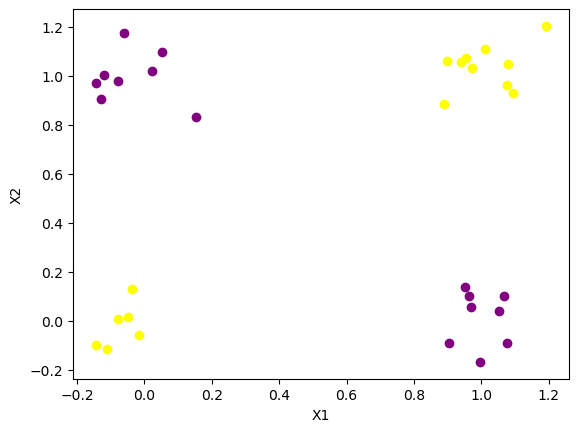

In [327]:
# XOR
input_train, target_train, input_test, target_test = get_data(n, 'XOR', Tr, mean, std)
plotPoints(input_train, target_train)

In [276]:
input_train

array([[-0.03975918,  1.03765292],
       [ 0.953852  , -0.0137586 ],
       [ 0.89055895,  0.11342524],
       [-0.12327145,  0.92572376],
       [ 0.05012097,  1.05124822],
       [ 0.9206147 ,  0.97618803],
       [ 1.1318298 , -0.01544873],
       [ 0.88671376,  0.1187745 ],
       [ 0.96239599,  1.12822787],
       [-0.08464296,  0.87609535],
       [ 0.98523786, -0.05822014],
       [ 0.12665751, -0.002214  ],
       [ 0.85582476,  0.90189826],
       [ 0.87238021,  0.90306996],
       [ 1.01234942,  0.06558352],
       [ 0.9867153 ,  0.23983085],
       [-0.09866208,  1.06783215],
       [ 0.04709034, -0.14558983],
       [ 0.1167249 ,  0.28343451],
       [-0.08138928,  1.12060201],
       [ 0.97395008, -0.17003879],
       [ 0.92227843,  1.0057401 ],
       [-0.07599837,  0.85975805],
       [ 0.88855849,  0.88557832],
       [ 0.89624506,  0.02763423],
       [ 0.02637224, -0.22804683],
       [ 0.99076028,  1.00997104],
       [-0.23413506, -0.05680398],
       [ 0.95245461,

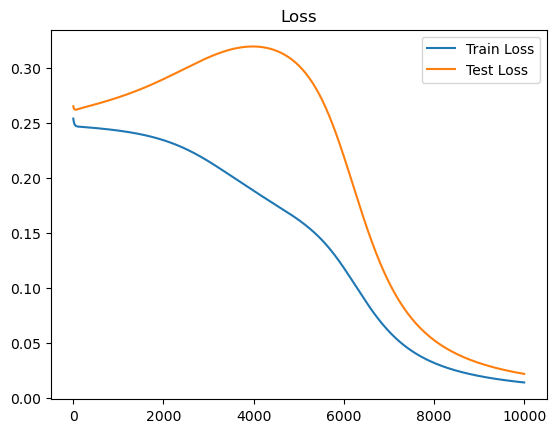

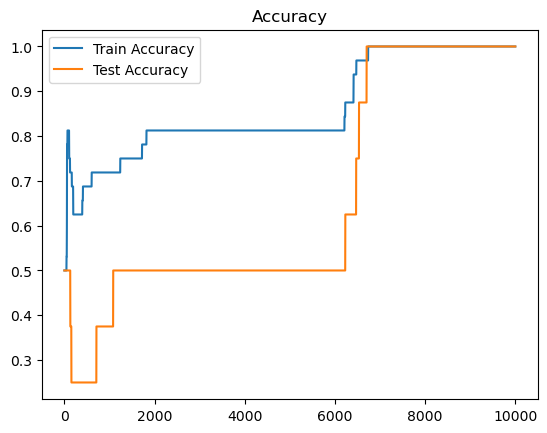

Train Loss: 0.013951517878829563
Train Accuracy: 1.0
Test Loss: 0.02176616162755469
Test Accuracy: 1.0


In [345]:
xor_params = training(input_train, target_train, input_test, target_test, 2, 1, 10000, 0.1, 'deterministic_gradient_descent')

In [306]:
ANN = ArtificialNeuralNetwork()
ANN.addLayer(2, input_shape=2)
ANN.addLayer(1)

In [307]:
ANN.printStructure()

Layers: [2, 2, 1]
Weights: [array([[ 0.28828707, -0.23850302],
       [ 0.32609581, -0.67269855]]), array([[ 0.28828707],
       [-0.23850302]])]
Biases: [array([[ 0.92521563, -0.30667632]]), array([[0.32609581]])]


[[1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]] [[0.61754097]
 [0.61109044]
 [0.61229698]
 [0.61573758]
 [0.61822963]
 [0.62230682]
 [0.612241  ]
 [0.61233948]
 [0.62400676]
 [0.61539351]
 [0.61072535]
 [0.60549048]
 [0.62120095]
 [0.6213031 ]
 [0.61248726]
 [0.61448479]
 [0.61752735]
 [0.60290348]
 [0.60928141]
 [0.61822135]
 [0.60918584]
 [0.62261091]
 [0.61525388]
 [0.6212097 ]
 [0.61124013]
 [0.60157849]
 [0.62300868]
 [0.60205765]
 [0.62285581]
 [0.60323223]
 [0.61732816]
 [0.62294051]] [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]] [[0.61415437]
 [0.60346123]
 [0.61799267]
 [0.60677429]
 [0.62237252]
 [0.60428455]
 [0.60247576]
 [0.61805667]] [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 

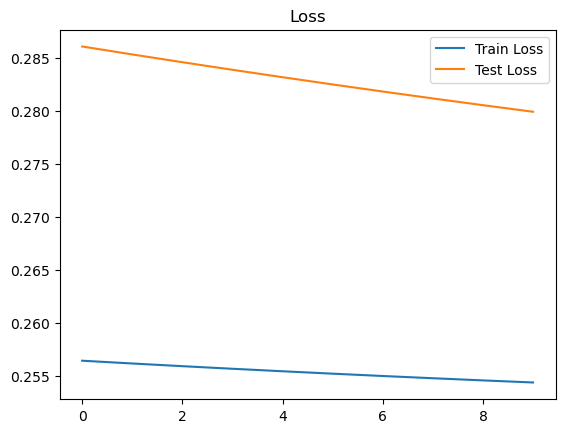

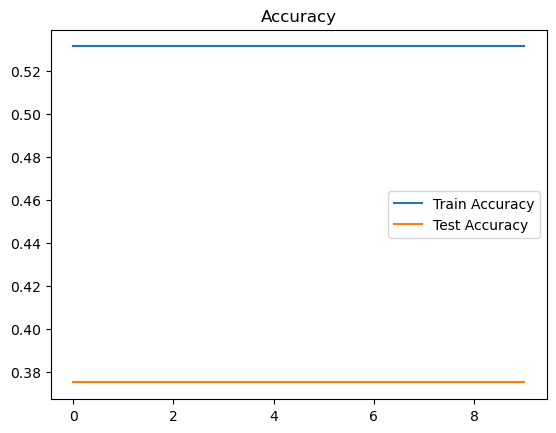

Train Loss: 0.25439612800014205
Train Accuracy: 0.53125
Test Loss: 0.279910751486791
Test Accuracy: 0.375


In [282]:
weights, biases = ANN.train(input_train, target_train, input_test, target_test, epochs=10, learning_rate=0.1, training_method='deterministic_gradient_descent')

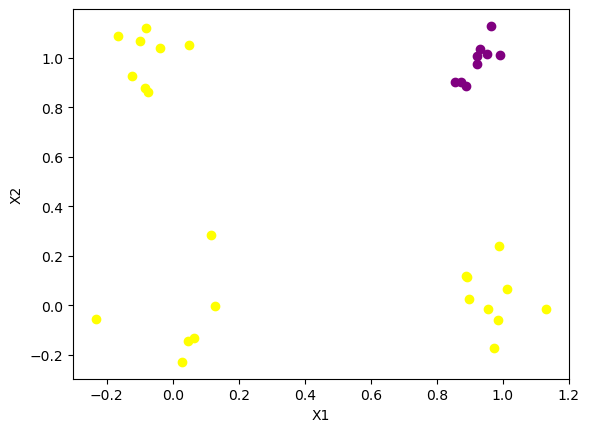

In [283]:
# AND
input_train, target_train, input_test, target_test = get_data(n, 'AND', Tr, mean, std)
plotPoints(input_train, target_train)

In [288]:
ANN = ArtificialNeuralNetwork()
ANN.addLayer(2, input_shape=2)
ANN.addLayer(1)

[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]] [[0.61279214]
 [0.60620699]
 [0.60743043]
 [0.61097903]
 [0.61348054]
 [0.61753845]
 [0.60735574]
 [0.60747365]
 [0.61925238]
 [0.61062911]
 [0.60583582]
 [0.60062093]
 [0.61642583]
 [0.61652792]
 [0.60761347]
 [0.60963323]
 [0.61278257]
 [0.59801829]
 [0.6044466 ]
 [0.61348135]
 [0.60428182]
 [0.61784541]
 [0.61048761]
 [0.61643259]
 [0.60636258]
 [0.59668391]
 [0.61824291]
 [0.59718993]
 [0.61809086]
 [0.59834828]
 [0.6125865 ]
 [0.61817778]] [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]] [[0.60928478]
 [0.59859383]
 [0.61323939]
 [0.60191926]
 [0.6176073 ]
 [0.5994177 ]
 [0.59758706]
 [0.61330107]] [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 

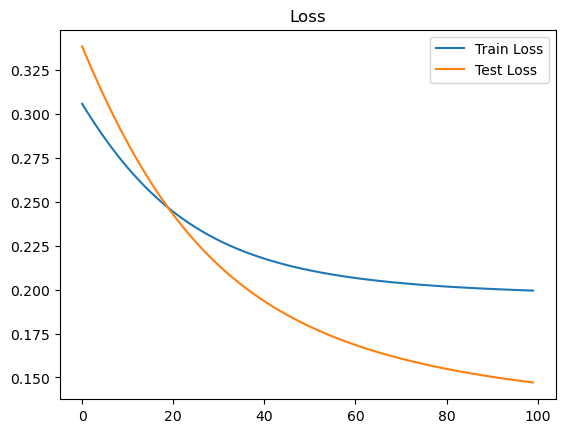

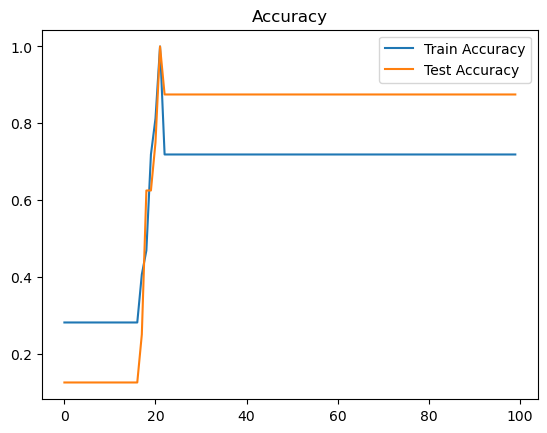

Train Loss: 0.19943311475855685
Train Accuracy: 0.71875
Test Loss: 0.14715961323920443
Test Accuracy: 0.875


In [289]:
weights, biases = ANN.train(input_train, target_train, input_test, target_test, epochs=100, learning_rate=0.1, training_method='deterministic_gradient_descent')

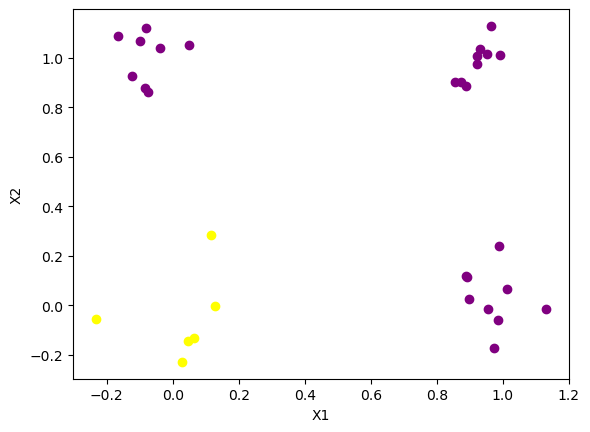

In [240]:
# OR
input_train, target_train, input_test, target_test = get_data(n, 'OR', Tr, mean, std)
plotPoints(input_train, target_train)

In [241]:
ANN = ArtificialNeuralNetwork()
ANN.addLayer(2, input_shape=2)
ANN.addLayer(1)

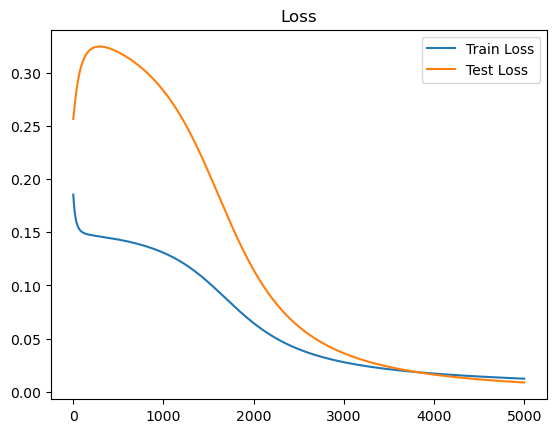

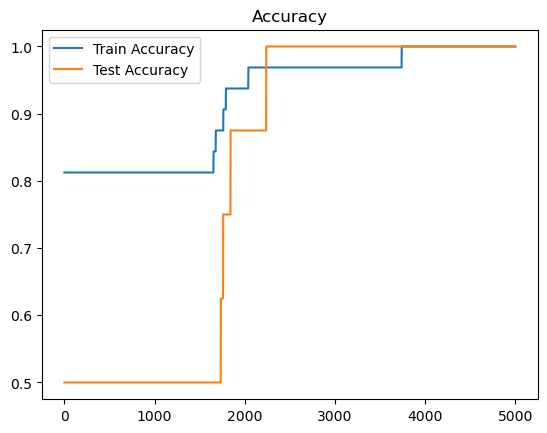

Train Loss: 0.012226132774076482
Train Accuracy: 1.0
Test Loss: 0.008634734264405136
Test Accuracy: 1.0


In [242]:
weights, biases = ANN.train(input_train, target_train, input_test, target_test, epochs=5000, learning_rate=0.1, training_method='deterministic_gradient_descent')